# Load Libraries

To install these libraries use: ```pip install numpy matplotlib librosa torch torchvision```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

import librosa
import librosa.display

In [2]:
music_file = '../data/fma_small/000/000002.mp3'
y, sr = librosa.load(music_file)

/home/udo/anaconda3/envs/music/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


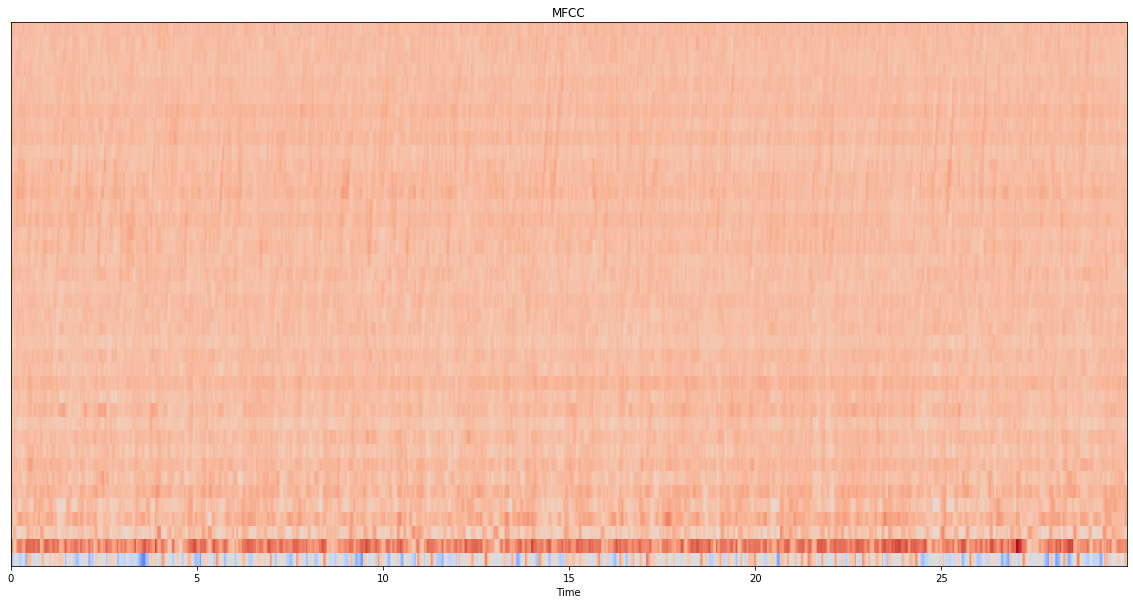

In [3]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
ax.set(title='MFCC')
fig.show()

# Extract Features With a Neural Network



In [4]:
import torch
import torchvision.models as models

# Pytorch provides a huge variety of different models
# I take in this case a ResNeXt50 with pre-trained parameters
model = models.resnext50_32x4d(pretrained=True)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [5]:
# A small function adding activation data of a hooked layer to a dictionary
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Take MFCC, change grayscale 1-channel to a repeated RGB 3-channel
pt_mfccs = torch.from_numpy(mfccs).repeat(3, 1, 1)
# Take (3, x, y) MFCC to be in an array
pt_mfccs = torch.unsqueeze(pt_mfccs, 0)

# Register hooks to get the activations while doing a forward propagation
model.avgpool.register_forward_hook(get_activation('avgpool'))
model.layer4.register_forward_hook(get_activation('layer4'))
# Do a forward propagation with the previously adapted MFCC
output = model(pt_mfccs)

# Print the shapes to see what we could use
print(activation['avgpool'].shape, activation['layer4'].shape, output.shape)

torch.Size([1, 2048, 1, 1]) torch.Size([1, 2048, 2, 41]) torch.Size([1, 1000])


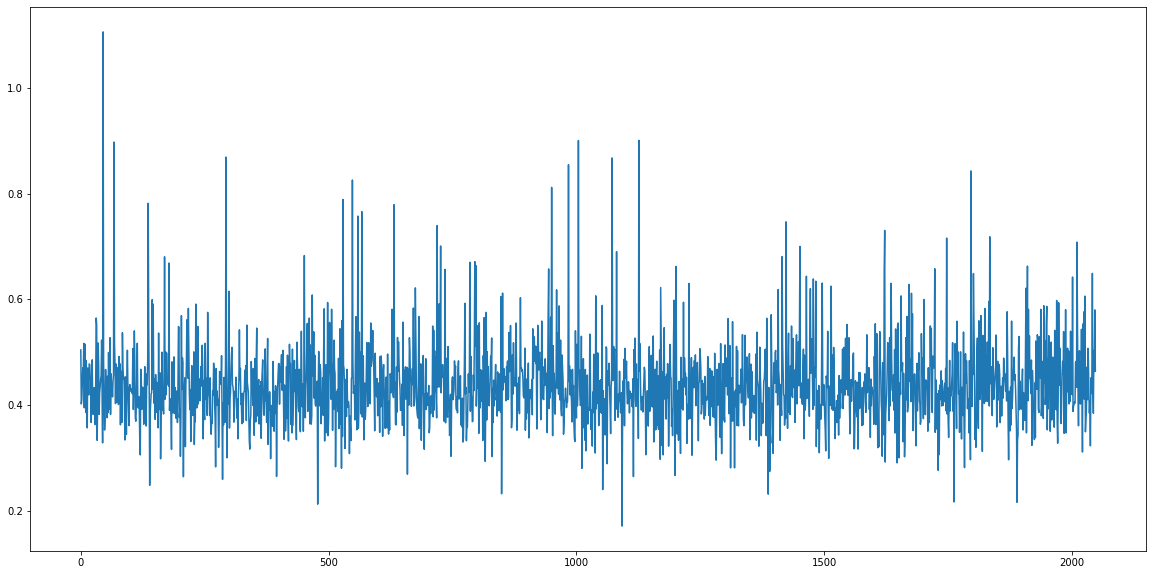

In [6]:
plt.plot(torch.reshape(activation['avgpool'], (-1,)))
plt.show()

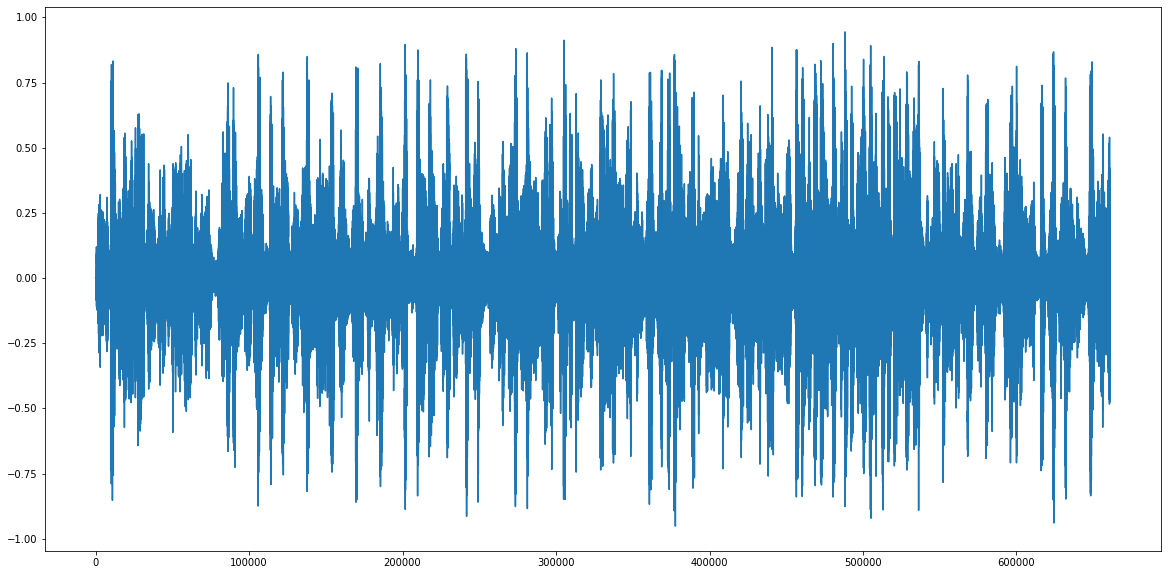

In [7]:
plt.plot(y)
plt.show()